In [76]:
import geopandas as gpd

import pandas as pd

import xml.etree.ElementTree as ET

import re

In [ ]:
# filter by intGapOrigin = 1 (native) (and Origin = Native for double check) and intGapPres = 1 (present) (and Presence = Known/extant for double check)

In [43]:
xml = "/media/muskrat/T7 Shield/eco_data/v3/native/GAP/extract/mABSQx_CONUS_Range_2001v1.xml"

# read xml file

tree = ET.parse(xml)

In [63]:
# find the title tag in the xml file

root = tree.getroot()

print(root)

<Element 'metadata' at 0x7b8ca7fc6180>


In [81]:
# find the first title tag in the xml file


name = ""
for title in root.iter("title"):
    if title.text != None:
        print(title.text)

        text = title.text
        # find words contained inside parentheses and add to a variable
        if ("(" in text) and (")" in text):
            text = re.findall(r"\((.*?)\)", text)
            name = text[0]

        else:
            print("no name")

        break
    else:
        print("no title")


print(name)

Abert's Squirrel (Sciurus aberti) mABSQx_CONUS_2001v1 Range Map
Sciurus aberti


In [82]:
zip = "/media/muskrat/T7 Shield/eco_data/v3/native/GAP/extract/mABSQx_CONUS_Range_2001v1.zip"

df = gpd.read_file(zip)

ValueError: Multiple files found in ZIP file. Only one file per ZIP: ['mABSQx_CONUS_Range_2001v1.CPG', 'mABSQx_CONUS_Range_2001v1.dbf', 'mABSQx_CONUS_Range_2001v1.prj', 'mABSQx_CONUS_Range_2001v1.sbn', 'mABSQx_CONUS_Range_2001v1.sbx', 'mABSQx_CONUS_Range_2001v1.shp', 'mABSQx_CONUS_Range_2001v1.shp.xml', 'mABSQx_CONUS_Range_2001v1.shx', 'Range_Season.lyr', 'mABSQx_CONUS_Range_2001v1.csv']

In [ ]:
df

In [ ]:
df.plot()

In [ ]:
df.crs

# check units
# df.crs.axis_info[0].unit_name

In [3]:
# converts crs to epsg:4326
df = df.to_crs("EPSG:4326")
df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
df.plot()

In [4]:
ecomap_loc = "/media/muskrat/T7 Shield/eco_data/ecomap_final/eco_map.geojson"

eco_map = gpd.read_file(ecomap_loc)

In [ ]:
eco_map

In [ ]:
eco_map.crs

In [ ]:
# convert df to geodataframe maybe not needed
df = gpd.GeoDataFrame(df, geometry="geometry")

(30.0, 45.0)

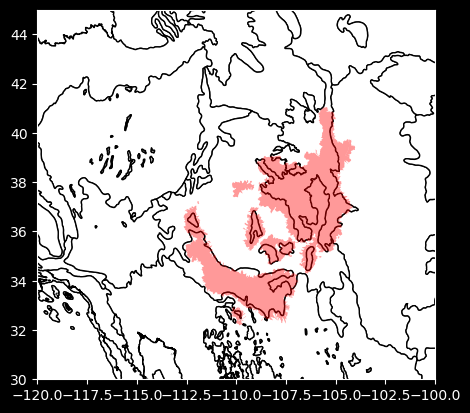

In [7]:
# plot ecomap and df on same map
base = eco_map.plot(color="white", edgecolor="black")
xmin, ymin, xmax, ymax = (-120, 30, -100, 45)

ax = df.plot(ax=base, color="red", alpha=0.4)

# set the x and y limits of the plot to the specified bounding box coordinates
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
# plot the GeoDataFrame with the specified bounding box
# df.plot(ax=base, color='red', extent=[xmin, xmax, ymin, ymax])

# df.plot(ax=base, color='red')

In [ ]:
df

In [8]:
# drop season code column and season name column from df

df = df.drop(columns=["SeasonCode", "SeasonName"])

In [9]:
# check if df geometry intersects with ecomap geometry

intersects = gpd.sjoin(df, eco_map)

In [ ]:
intersects.head()

In [11]:
# put unique values of unique_id in intersects into a list

unique_ids = list(intersects["unique_id"].unique())
unique_ids

['415', '310', '331', '416', '391', '339']

In [12]:
# create dataframe from eco_map that only contains the unique ids in unique_ids

eco_map_unique = eco_map[eco_map["unique_id"].isin(unique_ids)]
# eco_map_unique

In [ ]:
eco_map_unique.head()

In [14]:
overlay = gpd.overlay(df, eco_map, how="intersection")

<Axes: >

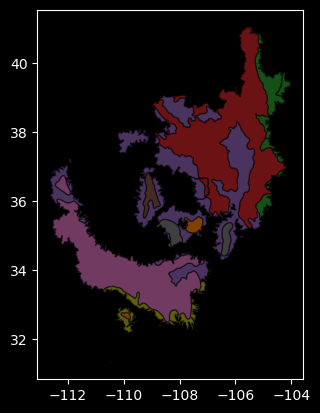

In [15]:
overlay.plot(alpha=0.5, edgecolor="k", cmap="tab10")

In [22]:
overlay

,unique_id,name,TYPE,geometry,area
0,310,Sierra Madre Occidental pine-oak forests,TEOW,"POLYGON ((-109.25476 32.85490, -109.25663 32.8...",0.005431
1,310,Sierra Madre Occidental pine-oak forests,TEOW,"POLYGON ((-110.25437 32.54513, -110.25477 32.5...",0.001073
2,310,Sierra Madre Occidental pine-oak forests,TEOW,"POLYGON ((-109.77369 32.46763, -109.77386 32.4...",0.049369
3,331,Arizona Mountains forests,TEOW,"POLYGON ((-107.18395 35.26205, -107.18763 35.2...",0.224371
4,391,Western short grasslands,TEOW,"MULTIPOLYGON (((-104.83078 35.79696, -104.8304...",1.363908
5,391,Western short grasslands,TEOW,"POLYGON ((-104.22385 39.71660, -104.22337 39.7...",0.126586
6,339,Colorado Rockies forests,TEOW,"MULTIPOLYGON (((-105.46658 41.04923, -105.4664...",8.780880
7,339,Colorado Rockies forests,TEOW,"POLYGON ((-107.29626 36.66175, -107.29573 36.6...",0.086231
8,416,Colorado Plateau shrublands,TEOW,"MULTIPOLYGON (((-110.59069 34.59213, -110.5904...",7.230902
9,416,Colorado Plateau shrublands,TEOW,"POLYGON ((-107.56274 36.69163, -107.55996 36.6...",0.198356


In [ ]:
o_area = overlay.area.sum()

o_area

In [ ]:
# add area column to overlay dataframe

overlay["area"] = overlay.geometry.area

In [ ]:
# find row with max area in overlay dataframe

overlay.loc[overlay["area"].idxmax()]

In [ ]:
# print overlay row

overlay.iloc[6]

In [32]:
# create a new dataframe from overlay where the first column is unique_id and the second column is the area of all the rows in overlay that have the same unique_id

overlay_areas = overlay[["unique_id", "area"]].groupby("unique_id").sum()

In [33]:
overlay_areas

,area
unique_id,
310,0.065720
331,7.579182
339,8.867111
391,1.490493
415,0.904236
416,7.429258


In [25]:
# add an area column to eco_map_unique dataframe

eco_map_unique["area"] = eco_map_unique.geometry.area

/tmp/ipykernel_20449/3789906643.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  eco_map_unique["area"] = eco_map_unique.geometry.area
/home/muskrat/miniconda3/envs/eco/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [34]:
# create a new dataframe from eco_map_unique where the first column is unique_id and the second column is the area of all the rows in eco_map_unique that have the same unique_id

eco_map_unique_areas = eco_map_unique[["unique_id", "area"]].groupby("unique_id").sum()

In [35]:
eco_map_unique_areas

,area
unique_id,
310,20.164750
331,10.662979
339,13.755770
391,44.114601
415,47.472658
416,32.997269


In [36]:
# combine eco_map_unique_areas and overlay_areas into a new dataframe where the first column is unique_id, the second column is area from overlays, and the third column is area from eco_map_unique

combined_areas = pd.concat([overlay_areas, eco_map_unique_areas], axis=1)
combined_areas.columns = ["overlay_area", "eco_map_unique_area"]

combined_areas

,overlay_area,eco_map_unique_area
unique_id,,
310,0.065720,20.164750
331,7.579182,10.662979
339,8.867111,13.755770
391,1.490493,44.114601
415,0.904236,47.472658
416,7.429258,32.997269


In [37]:
# if overlay_area / eco_map_unique_area > 0.2 then add unique_id to list of ids

native = combined_areas[
    combined_areas["overlay_area"] / combined_areas["eco_map_unique_area"] > 0.2
].index.tolist()

native

['331', '339', '416']

In [ ]:
# inter_repro = intersects.to_crs("EPSG:6933")

# inter_repro.crs.axis_info[0].unit_name